In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [20]:
def prune(a, ref):
    b = np.concatenate(([False], np.diff(a) < ref))
    c = np.concatenate(([False], np.diff(b.astype(int)) > 0))
    d = a[~c]
    if any(np.diff(a) < ref):
        d = prune(d, ref)
    return d


def generate_stim_times(stim_rate, stim_isi_min, stop_time):
    stim_times = np.sort(np.random.uniform(
        0, stop_time, stim_rate * stop_time))
    return prune(stim_times, stim_isi_min)


def generate_neurons(stim_times, make_post=False, **p):
    n_stim = len(stim_times)
    idxs = np.random.permutation(np.arange(n_stim).astype(int))
    n_stim_spikes = int(n_stim * p['stim_hit_chance'])
    idxs_stim_spikes = idxs[:n_stim_spikes]

    spikes = np.sort(np.concatenate([
        stim_times[idxs_stim_spikes] + p['stim_latency'],
        np.random.uniform(0, p['stop_time'], p['pre_rate'] * p['stop_time'])
    ]))
    pre_spikes = prune(spikes, p['refractory'])
    n_pre_spikes = len(pre_spikes)
    if make_post:
        n_post_spikes = int(n_pre_spikes * p['pre_hit_chance'])
        idxs_post_spikes = np.random.permutation(np.arange(n_pre_spikes).astype(int))[:n_post_spikes]

        post_spikes = np.sort(np.concatenate([
            pre_spikes[idxs_post_spikes] + p['latency'],
            np.random.uniform(0, p['stop_time'], int(p['post_rate'] * p['stop_time']))
        ]))
        post_spikes = prune(post_spikes, p['refractory'])
    
        return pre_spikes, post_spikes
    else:
        return pre_spikes
    

def histogram(val, bins):
    '''
    Assuming:
        val, bins are sorted
        bins increase monotonically and uniformly
        all(bins[0] <= v <= bins[-1] for v in val)
    '''
    result = np.zeros(len(bins) - 1).astype(int)
    search = np.searchsorted(bins, val, side='right')
    cnt = np.bincount(search)[1:len(result)]
    result[:len(cnt)] = cnt
    return result
    

def create_design_matrix(times, bins, n):
    result = [histogram(times, bins=bins)]
    for i in range(1, n):
        result.append(
            np.concatenate([
                np.zeros(i),
                result[0][:-i]
            ])
        )
    return np.array(result)


def OLS(X, y):
    dot, inv = np.dot, np.linalg.inv
    return dot(dot(inv(dot(X.T, X)), X.T), y)


def IV(pre, post, stim_times, stop_time, stim_duration, 
       sigma, refractory, latency, stim_latency, plot=False, verbose=False):

    bins = np.arange(0, stop_time + sigma, sigma)
    ref_steps = int(refractory / sigma)
    if verbose:
        print('Effective refractory time',ref_steps * sigma * 1000, 'ms')
    
    pre_binary_design = create_design_matrix(
        pre, bins, ref_steps)
    
    X = pre_binary_design[0]
    Z = pre_binary_design[1:]
    
    stim_steps = int(stim_duration / sigma)
    
    if verbose:
        print('Effective stimulation time', stim_steps * sigma * 1000, 'ms')
    
    S = create_design_matrix(
        stim_times, bins, stim_steps).sum(axis=0).astype(bool)
    
    Y = histogram(post, bins=bins)
    
    Z = Z.T
    Z = np.hstack((np.ones((Z.shape[0], 1)), Z))
    
    Z = Z[S]
    X = X[S]
    
    W = OLS(Z, X)
    X_fittedvalues = np.dot(W, Z.T)
    
    Y = Y[S]
    
    if plot:
        fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
        xlim = [0, 1000]
        mbins = bins[1:][S] * 1000
        mask = (mbins > xlim[0]) & (mbins <= xlim[1])
        mbins = mbins[mask]
        msigma = sigma * 1000 
        ax1.bar(
            mbins, X_fittedvalues[mask], 
            width=-msigma, align='edge', label='fitted values', color='grey', alpha=.5)
        ax1.bar(
            mbins, S[S][mask] * X_fittedvalues.max(), 
            width=-msigma, align='edge', label='S', alpha=.5, zorder=0, color='cyan')
        ax1.bar(
            mbins, X[mask] * X_fittedvalues.max()  * 2 / 3, 
            width=-msigma, align='edge', label='X', color='green', zorder=500)
        ax1.bar(
            mbins, Y[mask] * X_fittedvalues.max() * 1 / 3, 
            width=-msigma, align='edge', label='Y', color='red', zorder=1000)
        ax1.set_xlim(xlim)
    
        
        ax1.legend(
            bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
            ncol=4, mode="expand", frameon=False)

#     X_fittedvalues = X_fittedvalues[S]
    
#     if plot:
#         mbins = bins[1:][S] * 1000
#         mask = (mbins > xlim[0]) & (mbins <= xlim[1])
#         mbins = mbins[mask]
#         ax2.bar(
#             mbins, X_fittedvalues[mask], 
#             width=-msigma, align='edge', label='fitted values', color='grey', alpha=.5)
#         ax2.bar(
#             mbins, Y[mask] * X_fittedvalues.max() * 2 / 3, 
#             width=-msigma, align='edge', label='Y', color='red')
#         ax2.set_xlabel('time (ms)')
#         ax2.set_xlim(xlim)
        
    XX = np.array([np.ones(X_fittedvalues.shape[0]), X_fittedvalues])

    alpha, beta_IV = OLS(XX.T, Y.astype(float))
    if plot:
        fig.suptitle('beta {}'.format(beta_IV))
    
    return alpha, beta_IV

Effective refractory time 4.0 ms
Effective stimulation time 8.0 ms
(0.0070889038008224705, 0.47402902705235245)


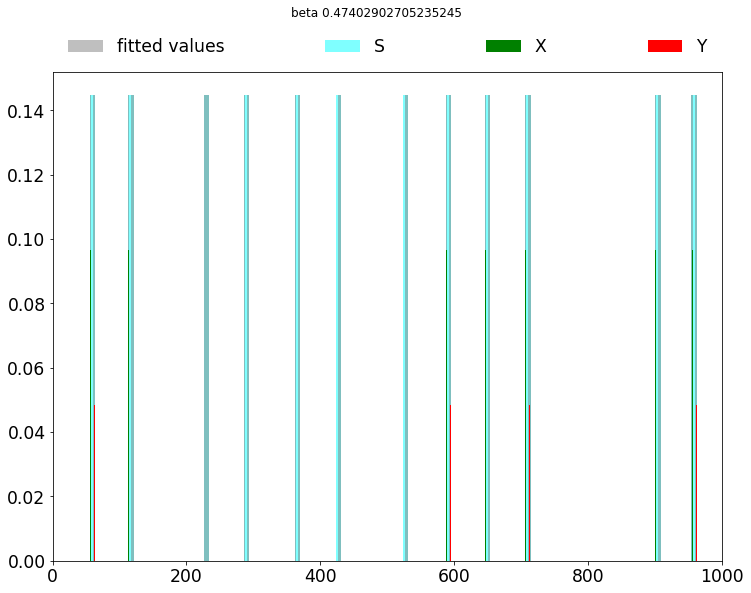

In [21]:
beta_AC = IV(
    pre=_A_spikes, post=_C_spikes, stim_times=_stim_times, **_iv_params,
    plot=True, verbose=True
)
print(beta_AC)

Effective refractory time 4.0 ms
Effective stimulation time 8.0 ms


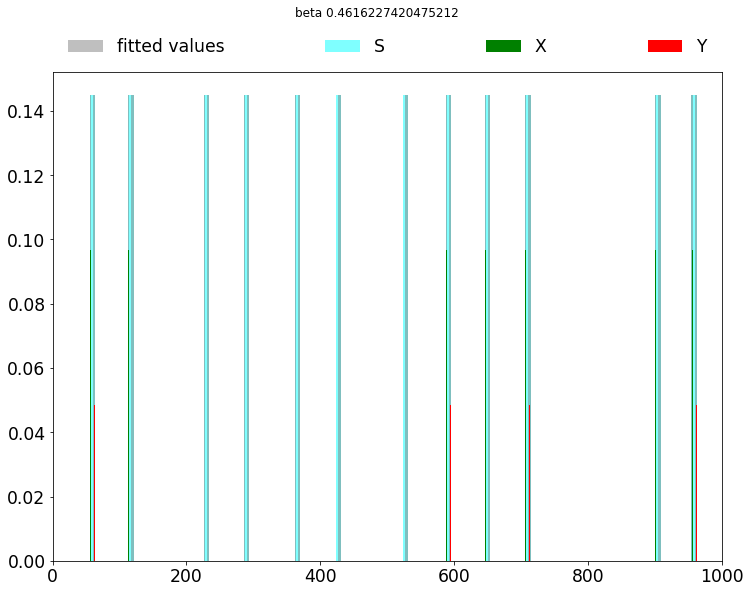

In [22]:
beta_BC = IV(
    pre=_B_spikes, post=_C_spikes, stim_times=_stim_times, **_iv_params,
    plot=True, verbose=True
)

In [15]:
_stim_params = {
    'stop_time': 2000, # seconds
    'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
    'stim_isi_min': 50e-3, # minimum inter stimulus interval
}
_neuron_params = {
    'refractory': 4e-3, # 4 ms
    'latency': 6e-3, # post response delay
    'pre_hit_chance': 0.5, # fraction of spikes that are driven by the presynaptic neuron
    'post_rate': 5, # Hz
    'pre_rate': 5, # base rate
    'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
    'stim_latency': 5e-4, # latency from stim to pre response
    'stop_time': _stim_params['stop_time'],
}
_iv_params = {
    'stim_duration': 8e-3, # size of chunk to clip out after (latency corrected) stim
    'sigma': 1e-3, # resolution for histograms
    'stop_time': _stim_params['stop_time'],
    'refractory': _neuron_params['refractory'],
    'latency': _neuron_params['latency'],
    'stim_latency': _neuron_params['stim_latency'],
}

_stim_times = generate_stim_times(**_stim_params) 

_A_spikes, _C_spikes = generate_neurons(_stim_times, make_post=True, **_neuron_params)

_B_spikes = generate_neurons(_stim_times, make_post=False, **_neuron_params)

In [31]:
results = []
for h in np.arange(.1, 1.1, .1):
    stim_params = {
        'stop_time': 2000, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 50e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 0,#6e-3, # post response delay
        'pre_hit_chance': .5, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': h, # fraction of spikes that are driven by the stimulation
        'stim_latency': 0,#5e-4, # latency from stim to pre response
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'stim_duration': 1e-3, # size of chunk to clip out after (latency corrected) stim
        'sigma': 1e-3, # resolution for histograms
        'stop_time': stim_params['stop_time'],
        'refractory': neuron_params['refractory'],
        'latency': neuron_params['latency'],
        'stim_latency': neuron_params['stim_latency'],
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    alpha_AC, beta_AC = IV(
        pre=A_spikes, post=C_spikes, stim_times=stim_times, **iv_params)
    
    alpha_BC, beta_BC = IV(
        pre=B_spikes, post=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC,
        'alpha_AC': alpha_AC,
        'alpha_BC': alpha_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})

In [32]:
results = pd.DataFrame(results)
# results

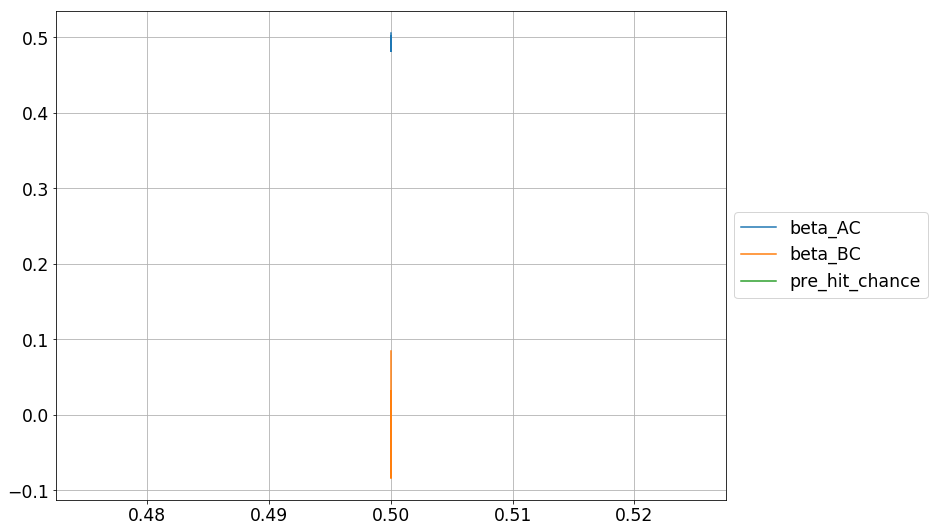

In [33]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
    'pre_hit_chance',
#     'C_induced_rate',
#     'alpha_AC',
#     'alpha_BC'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['pre_hit_chance'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))